In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


# Setup

In [1]:
# install tensorflow 2.15 since voxelmorph is not compatible with current build
try:
    import tensorflow as tf
    if not tf.__version__.startswith('2.15'):
      !pip uninstall -y tensorflow
      !pip install tensorflow==2.15
      import tensorflow as tf
except ImportError:
    !pip install tensorflow==2.15
    import tensorflow as tf

# install voxelmorph
try:
    import voxelmorph
    import neurite as ne
except ImportError:
    !pip install voxelmorph
    import voxelmorph
    import neurite as ne

# install silx
try:
    from silx.image import sift
except ImportError:
    !pip install silx
    from silx.image import sift

2024-08-07 14:50:11.661907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/linus/anaconda3/envs/CV/lib/python3.9/site-packages/pytools/persistent_dict.py:59: UserWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [2]:
import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2

from sklearn.model_selection import train_test_split

# Download dataset

In [3]:
# download dataset
filename = 'COMULISSHGBF.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/QQKxdTGoLPmEbc4/download/COMULISSHGBF.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [4]:
def load_data(jsonData, dataFolderPath, filterString='0001'):
    training_paths = []
    for i in range(len(jsonData['training_paired_images'])):
        tmproot, tmpext = os.path.splitext(jsonData['training_paired_images'][i]['moving'])
        root, ext = os.path.splitext(tmproot)
        splitRoot = root.split('_')
        if splitRoot[-1] == filterString:
            training_paths.append(jsonData['training_paired_images'][i])

    fixedData = []
    movingData = []
    for image in training_paths:
        fixedImg = nib.load(dataFolderPath + image['fixed'].removeprefix('.')).get_fdata()
        fixedData.append(fixedImg.astype(np.uint8))
        movingImg = nib.load(dataFolderPath + image['moving'].removeprefix('.')).get_fdata()
        movingImg_reshaped = movingImg.reshape(jsonData['tensorImageShape'][0]['0'][0], jsonData['tensorImageShape'][0]['0'][1], 3)
        movingData.append(movingImg_reshaped.astype(np.uint8))

    return np.array(fixedData), np.array(movingData)

In [5]:
# load data
with open('./COMULISSHGBF/COMULISSHGBF_dataset.json', 'r') as file:
  data_json = json.load(file)
dataFolder = './COMULISSHGBF'
data_fixed_raw, data_moved_raw = load_data(data_json, dataFolder)

(-0.5, 833.5, 833.5, -0.5)

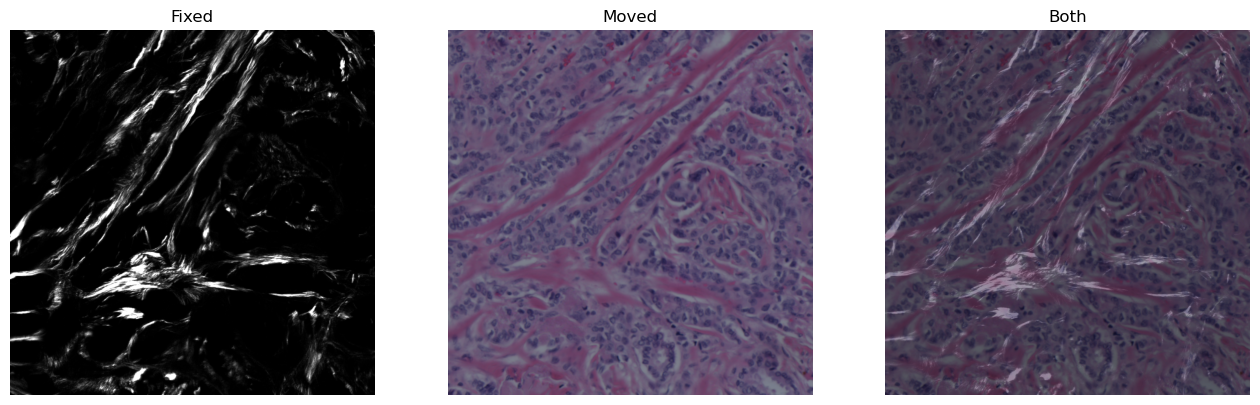

In [6]:
# preview data
img = 6

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(data_fixed_raw[img],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(data_moved_raw[img])
ax1.set_title("Moved")
ax1.axis("off")
ax2.imshow(data_fixed_raw[img],cmap='gray')
ax2.imshow(data_moved_raw[img], alpha=0.7)
ax2.set_title("Both")
ax2.axis("off")

# Preprocess Data

In [51]:
target_size = (512, 512)

# Resize images
data_fixed_resized = []
for sample in data_fixed_raw:
    data_fixed_resized.append(cv2.resize(sample,target_size))
data_fixed_resized = np.array(data_fixed_resized)

data_moved_resized = []
for sample in data_moved_raw:
    data_moved_resized.append(cv2.resize(sample,target_size))
data_moved_resized = np.array(data_moved_resized)

# Get moved images as grayscales
data_moved_gray = np.zeros_like(data_fixed_resized)
for idx, val in enumerate(data_moved_resized):
    data_moved_gray[idx] = cv2.cvtColor(val, cv2.COLOR_RGB2GRAY)
    
# Normalize images
x = (data_fixed_resized - np.min(data_fixed_resized)) / (np.max(data_fixed_resized) - np.min(data_fixed_resized))
y = (data_moved_gray - np.min(data_moved_gray)) / (np.max(data_moved_gray) - np.min(data_moved_gray))

(-0.5, 511.5, 511.5, -0.5)

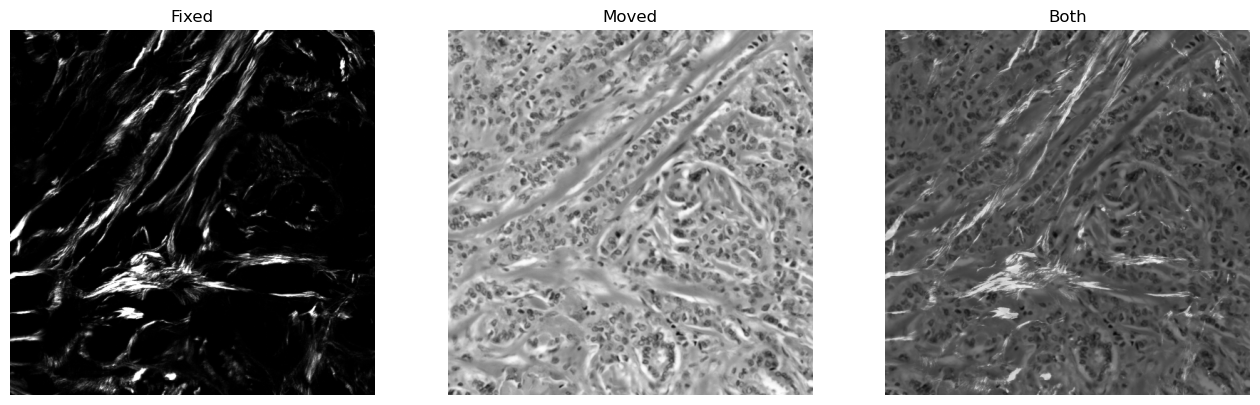

In [52]:
# view processed data
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(x[img],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(y[img],cmap='gray')
ax1.set_title("Moved")
ax1.axis("off")
ax2.imshow(x[img],cmap='gray')
ax2.imshow(y[img],cmap='gray', alpha=0.5)
ax2.set_title("Both")
ax2.axis("off")

In [85]:
sa = sift.LinearAlign(x[img])

/Users/linus/anaconda3/envs/CV/lib/python3.9/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/Users/linus/anaconda3/envs/CV/lib/python3.9/site-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)


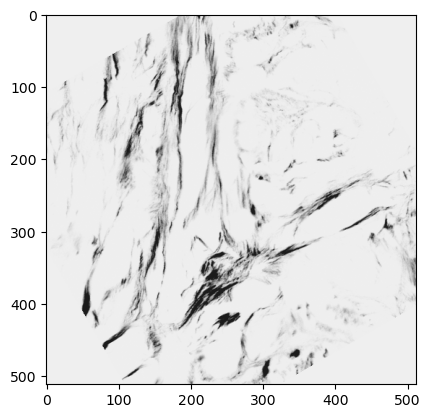

In [82]:
import scipy.ndimage
rotated = scipy.ndimage.rotate(x[img], 30, reshape=False)
plt.imshow(rotated,cmap='gray')

In [86]:
z = sa.align(y[img])

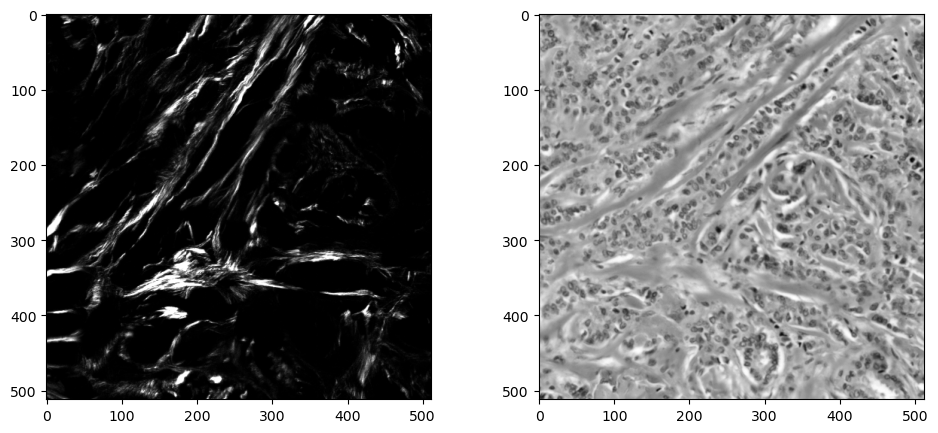

In [87]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.imshow(x[img], cmap="gray")
plt.subplot(1,3,2)
plt.imshow(y[img],cmap="gray")
if z is not None:
    plt.subplot(1,3,3)
    plt.imshow(z, cmap="gray")